In [1]:
import sympy as sm
from sympy import diff, Symbol, cos
from scipy.integrate import solve_ivp
import numpy as np
from sympy.physics.mechanics import dynamicsymbols
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

In [2]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [3]:
m1, m2, l1, l2, gty ,tau1, tau2, c1, c2, L, H = sm.symbols('m1 m2 l1 l2 g tau1 tau2 c1 c2 L H', real =True)
t = Symbol('t')
theta1, theta2 = dynamicsymbols('theta1 theta2')
theta1d = dynamicsymbols('theta1',1)
theta2d = dynamicsymbols('theta2',1)
theta1dd = dynamicsymbols('theta1',2)
theta2dd = dynamicsymbols('theta2',2)
gty, m1, m2, l1, l2, theta1, theta2, theta1d, theta2d, theta1dd, theta2dd, tau1, tau2

(g, m1, m2, l1, l2, theta1, theta2, theta1', theta2', theta1'', theta2'', tau1, tau2)

In [4]:
x1 = l1*sm.cos(theta1)
y1 = l1*sm.sin(theta1)
x2 = l1*sm.cos(theta1) + l2*sm.cos(theta2)
y2 = l1*sm.sin(theta1) + l2*sm.sin(theta2)

x1_dot = sm.diff(x1,t)
x2_dot = sm.diff(x2,t)
y1_dot = sm.diff(y1,t)
y2_dot = sm.diff(y2,t)

x1_dot , x2_dot, y1_dot , y2_dot

(-l1*sin(theta1)*theta1', -l1*sin(theta1)*theta1' - l2*sin(theta2)*theta2', l1*cos(theta1)*theta1', l1*cos(theta1)*theta1' + l2*cos(theta2)*theta2')

# dynamic modeling on manipulator without constraint

In [5]:
# kinetic energy
ke = (sm.Rational(1/2))*m1*(x1_dot**2)
ke += (sm.Rational(1/2))*m1*(y1_dot**2)
ke += (sm.Rational(1/2))*m2*(x2_dot**2)
ke += (sm.Rational(1/2))*m2*(y2_dot**2)
sm.simplify(ke)

l1**2*m1*theta1'**2/2 + l1**2*m2*theta1'**2/2 + l1*l2*m2*cos(theta1 - theta2)*theta1'*theta2' + l2**2*m2*theta2'**2/2

In [6]:
# potential energy
pe = m1*gty*y1
pe += m2*gty*y2
sm.expand(pe)

g*l1*m1*sin(theta1) + g*l1*m2*sin(theta1) + g*l2*m2*sin(theta2)

In [7]:
# the lagrangian equation
Ls = ke - pe

In [8]:
# force applied at joint 1
f1 = sm.diff(sm.diff(Ls,theta1d),t) - sm.diff(Ls,theta1)
f1sim = sm.expand(sm.simplify(f1))
f1sim

g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1) + l1**2*m1*theta1'' + l1**2*m2*theta1'' + l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + l1*l2*m2*cos(theta1 - theta2)*theta2''

In [9]:
# force applied at joint 2
f2 = sm.diff(sm.diff(Ls,theta2d),t) - sm.diff(Ls,theta2)
f2sim = sm.expand(sm.simplify(f2))
f2sim

g*l2*m2*cos(theta2) - l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + l1*l2*m2*cos(theta1 - theta2)*theta1'' + l2**2*m2*theta2''

In [10]:
#inertia term
it11 = f1sim.coeff(theta1dd) * theta1dd
it12 = f2sim.coeff(theta1dd) * theta1dd

it21 = f1sim.coeff(theta2dd) * theta2dd
it22 = f2sim.coeff(theta2dd) * theta2dd

m11 = f1sim.coeff(theta1dd)
m12 = f2sim.coeff(theta1dd)

m21 = f1sim.coeff(theta2dd)
m22 = f2sim.coeff(theta2dd)

M = sm.Matrix([[m11, m21], [m12, m22]])
M

Matrix([
[          l1**2*m1 + l1**2*m2, l1*l2*m2*cos(theta1 - theta2)],
[l1*l2*m2*cos(theta1 - theta2),                      l2**2*m2]])

In [11]:
#centrifugal / Coriolis force term,
C11 = (f1sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f1sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f1sim.coeff(theta2d * theta2d)*theta2d * theta2d)
C12 = (f2sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f2sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f2sim.coeff(theta2d * theta2d)*theta2d * theta2d)

C = sm.Matrix([[C11], [C12]])
C

Matrix([
[ l1*l2*m2*sin(theta1 - theta2)*theta2'**2],
[-l1*l2*m2*sin(theta1 - theta2)*theta1'**2]])

In [12]:
# gravity term
g1 = f1sim - sm.expand(it11) - sm.expand(it21) - sm.expand(C11)
g2 = f2sim - sm.expand(it12) - sm.expand(it22) - sm.expand(C12)
G = sm.Matrix([g1, g2])
G

Matrix([
[g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1)],
[                      g*l2*m2*cos(theta2)]])

In [13]:
tau = sm.Matrix([[tau1], [tau2]])
tau

Matrix([
[tau1],
[tau2]])

In [14]:
F = tau -C -G
F

Matrix([
[-g*l1*m1*cos(theta1) - g*l1*m2*cos(theta1) - l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + tau1],
[                      -g*l2*m2*cos(theta2) + l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + tau2]])

# Dynamic modeling subject to constraint

In [15]:
endefX = x2 - L #endeffector x trajectory
endefY = y2 - sm.cos(t) #endeffector y trajectory
endefX, endefY

(-L + l1*cos(theta1) + l2*cos(theta2), l1*sin(theta1) + l2*sin(theta2) - cos(t))

In [16]:
# get second order form
endefXdd = sm.diff(sm.diff(endefX,t),t)
endefYdd = sm.diff(sm.diff(endefY,t),t)
endefXdd, endefYdd

(-l1*sin(theta1)*theta1'' - l1*cos(theta1)*theta1'**2 - l2*sin(theta2)*theta2'' - l2*cos(theta2)*theta2'**2, -l1*sin(theta1)*theta1'**2 + l1*cos(theta1)*theta1'' - l2*sin(theta2)*theta2'**2 + l2*cos(theta2)*theta2'' + cos(t))

In [17]:
A11 = endefXdd.coeff(theta1dd)
A21 = endefXdd.coeff(theta2dd)

A12 = endefYdd.coeff(theta1dd)
A22 = endefYdd.coeff(theta2dd)

A = sm.Matrix([[A11, A21], [A12, A22]])
A

Matrix([
[-l1*sin(theta1), -l2*sin(theta2)],
[ l1*cos(theta1),  l2*cos(theta2)]])

In [18]:
b1 = endefXdd - sm.expand(A11)*theta1dd - sm.expand(A21)*theta2dd
b2 = endefYdd - sm.expand(A12)*theta1dd - sm.expand(A22)*theta2dd
b = -sm.Matrix([b1,b2])
b

Matrix([
[         l1*cos(theta1)*theta1'**2 + l2*cos(theta2)*theta2'**2],
[l1*sin(theta1)*theta1'**2 + l2*sin(theta2)*theta2'**2 - cos(t)]])

# Computation

In [19]:
# ode func for scipy rk45
theta1d_func = sm.lambdify(theta1d, theta1d)
theta2d_func = sm.lambdify(theta2d, theta2d)

t_span = (0, 200)
g_ = 0
m1_ = 1
m2_ = 1
l1_ = 1
l2_ = 1
tq1_ = 2
tq2_ = 0.4
c1_ = 1
c2_ = 0.1
y0 = [0,1,0,1]  # Initial state of the system


In [24]:
h_sn = (A*(M**(-1/2))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
j_sn = (M**(1/2)).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
k_sn = (b-(A*(M.inv()*F))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
F_sn = F.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
M_sn = M.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})

In [25]:
def dSdt(t,S, gt, m1, m2, l1, l2,c1, c2, torq1, torq2):
    thet1_, dtheta1_, thet2_, dtheta2_ = S
    
    print(S)
    
    h_n = h_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    j_n = j_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    k_n = k_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    psu_i = h_n.pinv()
    Fc = (j_n * psu_i * k_n)
    F_n = F_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    rf = F_n + Fc
    ra = M_sn.inv().subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf() * rf
    return [
        theta1d_func(dtheta1_),
        ra[0],
        theta2d_func(dtheta2_),
        ra[1]
    ]

In [26]:

solve_ivp_rk45 = solve_ivp(dSdt,t_span, y0, method='RK45', args = (g_,m1_,m2_,l1_,l2_,c1_,c2_,tq1_,tq2_))

[0. 1. 0. 1.]
[9.98998676e-06 1.00001598e+00 9.98998676e-06 9.99974026e-01]
[1.10485560e-05 1.00001768e+00 1.10485560e-05 9.99971274e-01]
[1.65730537e-05 1.00002652e+00 1.65724769e-05 9.99956911e-01]
[ 4.41957864e-05 -1.02031024e+04  4.41916848e-05  1.02051026e+04]
[ 1.63979193e-01 -6.17978821e+11 -1.63880989e-01  6.17978821e+11]
[ 9.33804891e+06  3.48864048e+19 -9.33804891e+06 -3.48864048e+19]
[ 2.52374318e+14 -7.00928122e+33 -2.52374318e+14  7.00928122e+33]
[2.20971120e-06 1.00000354e+00 2.20971120e-06 9.99994255e-01]
[3.31457558e-06 1.00000530e+00 3.31455251e-06 9.99991382e-01]
[ 8.83890728e-06 -8.06343744e+01  8.83874322e-06  8.26344206e+01]
[ 2.72114195e-04  3.16240322e+05 -2.52472543e-04 -3.16238322e+05]
[-9.55955111e-01  1.15197404e+09  9.55977208e-01 -1.15197404e+09]
[ 1.66558907e+03  1.35714213e+12 -1.66558905e+03 -1.35714214e+12]
[4.41942239e-07 1.00000071e+00 4.41942239e-07 9.99998851e-01]
[ 6.62913710e-07 -1.90895324e+03  6.62912787e-07  5.73085973e+03]
[-1.50042591e-02 -1.

[1.07990846e-08 1.00000002e+00 1.07990844e-08 9.99999972e-01]
[1.08011032e-08 1.00000002e+00 1.08011029e-08 9.99999972e-01]
[1.08036263e-08 1.00000002e+00 1.08036261e-08 9.99999972e-01]
[1.08036263e-08 1.00000002e+00 1.08036261e-08 9.99999972e-01]
[1.08490436e-08 1.00000002e+00 1.08490433e-08 9.99999972e-01]
[1.08717522e-08 1.00000002e+00 1.08717520e-08 9.99999972e-01]
[ 1.09852953e-08  1.45425690e+08  1.09852951e-08 -1.45425688e+08]
[-9.60372507e-03 -2.56831708e+23  9.60374707e-03  2.56831708e+23]
[ 1.59531493e+13 -4.26620286e+38 -1.59531493e+13  4.26620286e+38]
[-1.26866119e+28 -3.27237459e+66  1.26866119e+28  3.27237459e+66]
[1.08127098e-08 1.00000002e+00 1.08127095e-08 9.99999972e-01]
[1.08172515e-08 1.00000002e+00 1.08172513e-08 9.99999972e-01]
[1.08399601e-08 1.00000002e+00 1.08399599e-08 9.99999972e-01]
[1.08439972e-08 1.00000002e+00 1.08439970e-08 9.99999972e-01]
[1.08490436e-08 1.00000002e+00 1.08490433e-08 9.99999972e-01]
[1.08490436e-08 1.00000002e+00 1.08490433e-08 9.999999

[1.08609899e-08 1.00000002e+00 1.08609897e-08 9.99999972e-01]
[1.08609904e-08 1.00000002e+00 1.08609901e-08 9.99999972e-01]
[1.08609927e-08 1.00000002e+00 1.08609925e-08 9.99999972e-01]
[1.08609931e-08 1.00000002e+00 1.08609929e-08 9.99999972e-01]
[1.08609936e-08 1.00000002e+00 1.08609934e-08 9.99999972e-01]
[1.08609936e-08 1.00000002e+00 1.08609934e-08 9.99999972e-01]
[1.08610029e-08 1.00000002e+00 1.08610027e-08 9.99999972e-01]
[ 1.08610076e-08  1.88199178e+03  1.08610073e-08 -1.87999178e+03]
[ 1.11720700e-08  1.05168581e+11  1.05499914e-08 -1.05168581e+11]
[-1.42236637e-03 -1.68814931e+31  1.42238810e-03  1.68814931e+31]
[ 2.14752683e+17 -2.54879184e+51 -2.14752683e+17  2.54879184e+51]
[-1.55227432e+37 -2.62244567e+89  1.55227432e+37  2.62244567e+89]
[1.08609955e-08 1.00000002e+00 1.08609952e-08 9.99999972e-01]
[ 1.08609964e-08  3.77197839e+02  1.08609962e-08 -3.75197839e+02]
[ 1.08734426e-08  8.41344322e+08  1.08485593e-08 -8.41344319e+08]
[-2.26489786e-06 -8.64330621e+24  2.286619

[ 1.08609943e-08  8.27137715e+00  1.08609940e-08 -6.27137714e+00]
[ 1.08609943e-08  9.03554851e+00  1.08609940e-08 -7.03554850e+00]
[ 1.08609943e-08  9.16940577e+00  1.08609940e-08 -7.16940578e+00]
[ 1.08609943e-08  1.10046751e+01  1.08609940e-08 -9.00467514e+00]
[ 1.08609943e-08  1.30076224e+01  1.08609940e-08 -1.10076224e+01]
[ 1.08609944e-08  3.85409806e+01  1.08609940e-08 -3.65409807e+01]
[ 1.08609944e-08  8.84258530e+00  1.08609940e-08 -6.84258539e+00]
[ 1.08609944e-08  1.26923120e+02  1.08609939e-08 -1.24923121e+02]
[ 1.08609944e-08  5.65649279e+02  1.08609939e-08 -5.63649279e+02]
[ 1.08609943e-08  9.53645911e+00  1.08609940e-08 -7.53645912e+00]
[ 1.08609943e-08  9.75935976e+00  1.08609940e-08 -7.75935977e+00]
[ 1.08609943e-08  1.09977891e+01  1.08609940e-08 -8.99778911e+00]
[ 1.08609943e-08  1.12940669e+01  1.08609940e-08 -9.29406691e+00]
[ 1.08609943e-08  1.16178988e+01  1.08609940e-08 -9.61789876e+00]
[ 1.08609943e-08  1.15636855e+01  1.08609940e-08 -9.56368555e+00]
[ 1.086099

[ 1.08609944e-08  2.81852160e+03  1.08609939e-08 -2.81652160e+03]
[ 1.08609944e-08  2.90867329e+03  1.08609939e-08 -2.90667330e+03]
[ 1.08609944e-08  3.00615920e+03  1.08609939e-08 -3.00415920e+03]
[ 1.08609944e-08  2.98876133e+03  1.08609939e-08 -2.98676133e+03]
[ 1.08609944e-08  3.17811324e+03  1.08609939e-08 -3.17611324e+03]
[ 1.08609944e-08  3.30135783e+03  1.08609939e-08 -3.29935783e+03]
[ 1.08609944e-08  4.03246843e+03  1.08609939e-08 -4.03046844e+03]
[ 1.08609944e-08  4.22564601e+03  1.08609939e-08 -4.22364601e+03]
[ 1.08609944e-08  4.43007022e+03  1.08609939e-08 -4.42807022e+03]
[ 1.08609944e-08  4.39164123e+03  1.08609939e-08 -4.38964123e+03]
[ 1.08609944e-08  5.12785540e+03  1.08609939e-08 -5.12585540e+03]
[ 1.08609944e-08  5.80553353e+03  1.08609939e-08 -5.80353353e+03]
[ 1.08609944e-08  1.22783469e+04  1.08609939e-08 -1.22763469e+04]
[ 1.08609944e-08  1.18363684e+04  1.08609939e-08 -1.18343684e+04]
[ 1.08609944e-08  1.91576573e+04  1.08609939e-08 -1.91556573e+04]
[ 1.086099

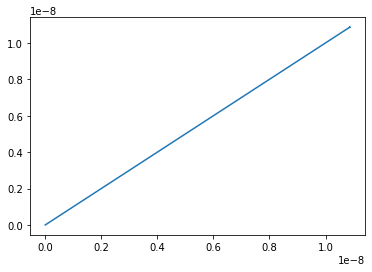

In [27]:
plt.plot(solve_ivp_rk45.t, solve_ivp_rk45.y[0], label=f'$X_{0}(t)$')

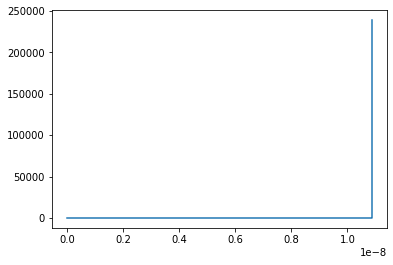

In [28]:
plt.plot(solve_ivp_rk45.t, solve_ivp_rk45.y[1], label=f'$X_{1}(t)$')

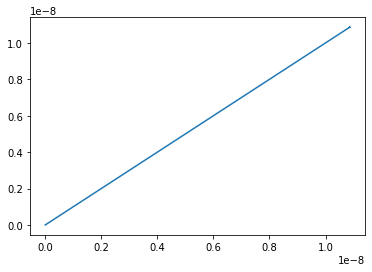

In [29]:
plt.plot(solve_ivp_rk45.t, solve_ivp_rk45.y[2], label=f'$X_{2}(t)$')

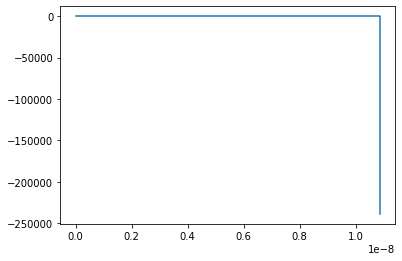

In [30]:
plt.plot(solve_ivp_rk45.t, solve_ivp_rk45.y[3], label=f'$X_{3}(t)$')